<a href="https://colab.research.google.com/github/Raashidh-Rizvi/Brain-Tumor-Detection/blob/main/notesbooks%20/%20IT24103178_Noise_Outlier_Removal_%26_Dimensionality_Reduction_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install opencv-python scikit-image

# Clone the GitHub repository
!git clone https://github.com/Raashidh-Rizvi/Brain-Tumor-Detection.git

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import exposure

# Define directories
train_dir = "/content/Brain-Tumor-Detection/data/Training"
test_dir = "/content/Brain-Tumor-Detection/data/Testing"

# Load images from training directory
image_paths = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

# Load and preprocess images (subset for demo; use all for full run)
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths[:100]]  # Grayscale for MRI
images = [cv2.resize(img, (128, 128)) for img in images if img is not None]  # Resize for consistency
print(f"Loaded {len(images)} images")

# Noise Removal - Median filter
denoised_images = [cv2.medianBlur(img, 3) for img in images]  # Kernel size 3

# Outlier Detection - Mean intensity
mean_intensities = [np.mean(img) for img in denoised_images]
df = pd.DataFrame({'mean_intensity': mean_intensities})

# IQR method
Q1 = df['mean_intensity'].quantile(0.25)
Q3 = df['mean_intensity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
cleaned_indices = df[(df['mean_intensity'] >= lower_bound) & (df['mean_intensity'] <= upper_bound)].index
cleaned_images = [denoised_images[i] for i in cleaned_indices]

print(f"Original images: {len(denoised_images)}, After outlier removal: {len(cleaned_images)}")

# Save sample cleaned images
for i, img in enumerate(cleaned_images[:5]):
    cv2.imwrite(f'cleaned_image_{i}.jpg', img)

Cloning into 'Brain-Tumor-Detection'...
remote: Enumerating objects: 6771, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6771 (delta 2), reused 2 (delta 0), pack-reused 6760 (from 3)
Receiving objects: 100% (6771/6771), 142.31 MiB | 20.90 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (7025/7025), done.
Loaded 100 images
Original images: 100, After outlier removal: 96


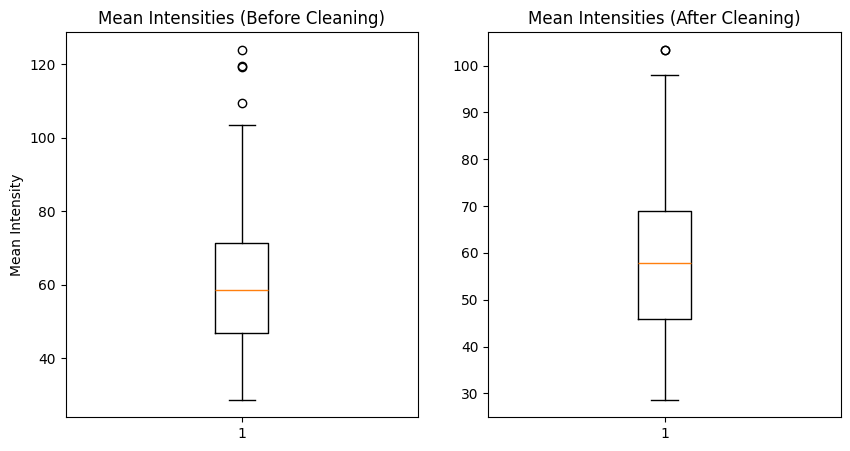

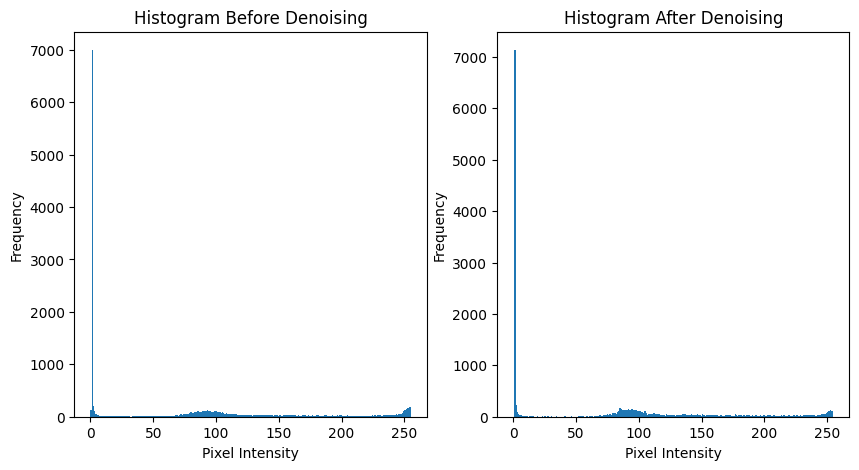

In [ ]:
# EDA for Outlier/Noise Removal
# Boxplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(mean_intensities)
plt.title('Mean Intensities (Before Cleaning)')
plt.ylabel('Mean Intensity')

plt.subplot(1, 2, 2)
plt.boxplot([np.mean(img) for img in cleaned_images])
plt.title('Mean Intensities (After Cleaning)')
plt.show()

# Histogram for noise
sample_idx = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(images[sample_idx].ravel(), bins=256, range=(0, 255))
plt.title('Histogram Before Denoising')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(denoised_images[sample_idx].ravel(), bins=256, range=(0, 255))
plt.title('Histogram After Denoising')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Flatten cleaned images
flattened_images = np.array([img.flatten() for img in cleaned_images])

# Standardize data
scaler = StandardScaler()
scaled_images = scaler.fit_transform(flattened_images)

# Apply PCA
pca = PCA(n_components = len(cleaned_images))  # Adjust components as needed
reduced_images = pca.fit_transform(scaled_images)

print(f"Original shape: {flattened_images.shape}, Reduced shape: {reduced_images.shape}")

Original shape: (96, 16384), Reduced shape: (96, 96)


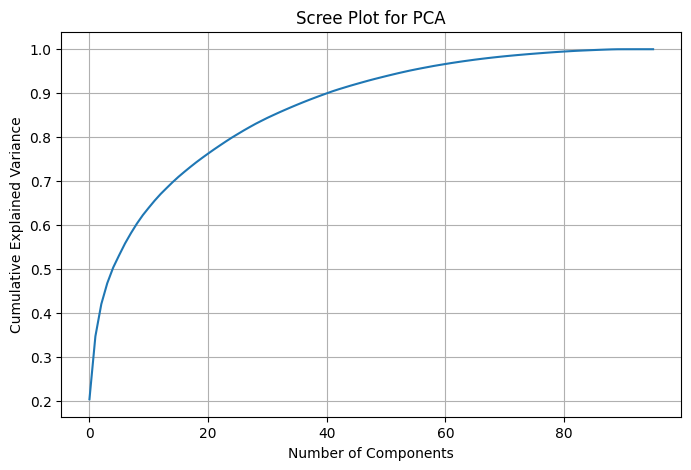

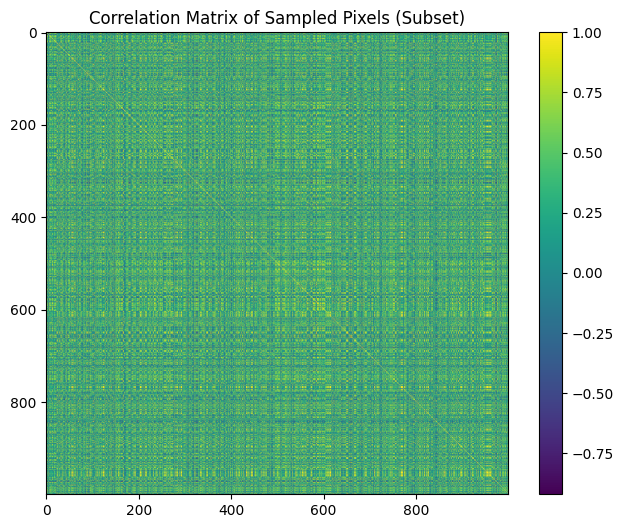

In [ ]:
# EDA for Dimensionality Reduction
# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.grid(True)
plt.show()

# Correlation matrix (subset to avoid memory issues)
n_pixels = 1000
random_pixels = np.random.choice(flattened_images.shape[1], size=n_pixels, replace=False)
subset_data = flattened_images[:10, random_pixels]  # Use 10 images, sampled pixels
corr_matrix = pd.DataFrame(subset_data).corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis')
plt.title('Correlation Matrix of Sampled Pixels (Subset)')
plt.colorbar()
plt.show()